Projet réalisé dans le cadre du module *Optimisation Discrète* de la spécialité *Génie Mathématique* à l'INSA Rennes.

**Auteur** : Tangi Tassin

**Version** : 3

**Notebook terminé le** : 24/05/2020 (dans cette version)

**Changelog** (depuis la version 2, rendu intermédiaire) :
- Des changements de fond mineurs
- Relecture et correction du français
- Tentative d'implémentation de l'algorithme de Kosaraju (non terminé)

**Objectifs principaux** :
- Résoudre le problème du voyageur en implémentant l'algorithme de Little ;
- Proposer et développer une programmation linéaire de ce problème ;
- Tester ces algorithmes dans différentes conditions

In [1]:
import numpy as np
import pandas as pd
from pulp import *
import os, os.path
from IPython.display import clear_output
from itertools import product # Produit cartésien
import re # Expression régulière
from time import time # Gestion de la durée
import matplotlib.pyplot as plt # Affichage de graphiques
%matplotlib inline
import seaborn as sns # Affichage amélioré des graphiques
sns.set()
from random import shuffle,random, seed # Aléatoire
from sklearn.linear_model import LinearRegression # Régression linéaire

Choix du mode de lancement de Gurobi (en fonction de votre installation) :

In [2]:
gurobiSolv = "GUROBI_CMD"
#gurobiSolv = "GUROBI"

Pourquoi utiliser **Numpy** et **Pandas** dans ce problème ?
- Numpy permet de faciliter les calculs "matriciels" (soustraction sur toute une ligne par exemple) et de les rendre plus rapide. Des détails sont donnés plus bas
- Pandas permet en plus de conserver aisément le nom des noeuds et ainsi de moins s'embêter avec des bijections "numéro de noeud" <-> "nom de noeud"

# Code principal

La classe principale "Little" contient l'algorithme du même nom permettant de rendre le cycle hamiltonien optimal.

Ici on utilise uniquement la **matrice d'adjacence** pondérée du graphe. Le graphe est **supposé simple et connexe**, composé de **n** sommets. Dans beaucoup d'exemples le graphe sera également non-orienté mais les algorithmes fonctionnent de la même manière avec des graphes orientés.
Pour qu'un cycle couvrant tous les sommets existe dans un graphe, il faut que celui-ci soit **fortement connexe** (on peut le prouver en supposant qu'il existe un tel cycle). Il est donc possible que les algorithmes ne trouvent pas de solution, car aucun cycle, même très grand, n'existera.

Un travail supplémentaire intéressant pourrait être de partir d'un p-graphe et de le rendre **simple** en supprimant les boucles (inutiles pour notre problème) et en gardant uniquement les arrêtes de taille minimale. Ce problème n'est pas difficile mais nécessite l'implémentation d'autres outils.

## Classe Little

In [3]:
class Little:
    
    def __init__(self, dataF):
        self.dataF = dataF
        self.maxi = np.inf
        
    def reduc_matrice(df):
        """Réduit le df par ligne et par colonne"""
        mat = df.values
        dim = mat.shape

        somme = 0
        
        # Réduction par ligne
        for i in range(dim[0]):
            if 0 not in mat[i,:]:
                mini = np.inf
                indMin = -1
                for j in range(dim[1]):
                    if not(np.isnan(mat[i,j])) and mat[i,j] < mini:
                        indMin = j
                        mini = mat[i,j]

                if indMin != -1:
                    somme += mini
                    mat[i,:] -= mini

        # Réduction par colonne
        for j in range(dim[1]):
            if 0 not in mat[:,j]:
                mini = np.inf
                indMin = -1
                for i in range(dim[0]):
                    if not(np.isnan(mat[i,j])) and mat[i,j] < mini:
                        indMin = i
                        mini = mat[i,j]

                if indMin != -1 and mini != 0:
                    somme += mini
                    mat[:,j] -= mini

        return [df,somme]
     
        
    def calcul_regrets(df, ligne = None):
        """Calcule les regrets d'un dF"""
        regrets = np.empty(df.shape)
        regrets[:] = np.nan
        
        mat = df.values
        dim = mat.shape
        
        zeros = np.argwhere(df.values == 0)
        
        
        '''On peut éventuellement se restreindre aux regrets 
        d'une seule ligne afin d'éviter des calculs inutiles'''
        if(ligne != None and ligne in df.index):
            j = 0
            noms = df.index
            while(noms[j] != ligne):
                j = j + 1
            ligne = j
        elif ligne not in range(dim[0]):
            ligne = None
        
        
        for k in zeros:
            if ligne == None or k[0] == ligne:
                regrets[k[0],k[1]] = 0

                mini = np.inf
                for i in range(dim[0]):
                    if i != k[0] and not(np.isnan(mat[i,k[1]])) \
                    and mat[i,k[1]] < mini:
                        mini = mat[i,k[1]]
                regrets[k[0],k[1]] += mini


                mini = np.inf
                for j in range(dim[1]):
                    if j != k[1] and not(np.isnan(mat[k[0],j])) \
                    and mat[k[0],j] < mini:
                        mini = mat[k[0],j]

                regrets[k[0],k[1]] += mini
        
        if ligne == None:
            return pd.DataFrame(regrets,index=df.index,
                                columns=df.columns)
        
        else:
            regrets = regrets[ligne,:]
            return regrets
    
    
    def del_ligne_col(df,i,j):
        """Supprime la ligne i et la colonne j
         de df (retourne une copie)"""
        return df.drop(index = i, columns = j)
    
    
    
    def little(self, df, liste, cout):
        "Algorithme récursif de Little (O(e^n))"
        #Gestion préalable des types d'entrées
        if not(isinstance(liste,list)):
            liste = [liste]
        
        # Elimination des sous-tournées
        if(len(liste) > 1):
            df.loc[liste[-1],liste[0]] = np.nan
        
        '''Réduction de la matrice et 
        obtention du cout supplémentaire'''
        [df,coutSupp] = Little.reduc_matrice(df)
        cout += coutSupp
        
        # Si le cout dépasse le max on arrête cette branche
        if(cout >= self.maxi):
            del df, liste, cout
            return None
        
        
        '''Si la matrice est de taille 2*2 cela 
        signifie qu'il ne reste que le retour'''
        if(len(df) == 2):
            self.maxi = cout
            return liste + list(set(df.index) & 
                                set(df.columns)) + [liste[0]]
        
        elif(len(df) <= 1):
            print("nbligne")
            del df, liste, cout
            return None
        
        
        '''Sinon on calcule le chemin supposé optimal
        en trouvant le regret max'''
        reg = Little.calcul_regrets(df,liste[-1])
        j = -1
        regMax = -1
        for k in range(len(reg)):
            if not(np.isnan(reg[k])) and reg[k] > regMax:
                regMax = reg[k]
                j = k
        
        
        # S'il n'y a aucun regret on arrête cette branche
        if j == -1:
            del df, liste, cout
            print("regrets")
            return None
        
        # Sinon on prend le nouveau chemin vers 'j'
        j = df.columns[j]
        df1 = Little.del_ligne_col(df,liste[-1],j)
        val1 = self.little(df1,liste + [j],cout)


        # Et on ne "prend pas" le nouveau chemin vers 'j'
        '''Si le nouveau cout (cout + regret) est plus grand 
        que le maxi on arrête la branche'''
        if cout + regMax >= self.maxi:
            val2 = None
        
        else:
            '''A noter qu'ici df2 est littéralement df, 
            (même adresse) mais cela n'a pas d'importance'''
            df2 = df
            df2.loc[liste[-1],j] = np.nan
            val2 = self.little(df2, liste,cout)
            
        
        del df, liste, cout
        
        if(val2 != None):
            return val2
        
        else:
            return val1
        
    def solve(self, depart=None):
        """Fonction de démarrage de l'algorithme"""
        df = self.dataF.copy()
        self.maxi = np.inf
        if(depart == None or (depart not in df.columns)):
            liste = [df.columns[0]]
        else:
            liste = [depart]
        return [self.little(df, liste, 0),self.maxi]

L'algotirhme de *Little* codé ici est basé sur le pseudo-code proposé dans le document "*voyageur de commerce*" joint au Projet d'Optimisation discrète ainsi que sur un cours d'introduction aux méthodes *Branch & Bound* de l'école *ISEN Lilles*. L'algorithme est ici codé en **récursif** : cela permet de rendre le programme **plus rapide** mais éventuellement **gourmand en ressource mémoire**. Pour cette raison la branche supposée "optimale" est calculée en premier afin de réduire le plus possible le nombre de branches suivantes à déterminer. De plus les variables sont régulièrement supprimées afin d'économiser de l'espace mémoire.

Il est à noter que le code des fonctions en lien avec l'algorithme de Little peut sembler redondant : mise en mémoire de l'adresse des valeurs du dataFrame alors que l'on aurait pu récupérer ces valeurs à chaque calcul. Cependant il s'avère que ce code est le plus efficace que j'ai pu écrire pour ce problème. En effet :
- Si l'on passe par les valeurs sous Pandas plutôt que sous Numpy, les calculs deviennent considérablement plus long (chez moi une résolution passant par exemple de 20 à 50 secondes)
- Le stockage des ensembles (range, product...) donne un code plus propre mais rend également les calculs beaucoup plus long, jusqu'à une perte de 20 secondes quand les ensembles sont grands.

## Classe Programmation Linéaire

In [4]:
 class PL_voyage:

    def __init__(self,dataF):
        self.dataF = dataF

        self.sous_tour = []
        self.P = dataF.values # Matrice des poids
        self.X = [] # Matrice des variables binaires
        self.declaration_vars() # Création des variables
    
    def declaration_vars(self):
        n = self.P.shape[0]
        for i in range(n):
            self.X += [list(range(n))]
            for j in range(n):
                # Si l'arrête n'existe pas, on ne créé pas de variable
                if np.isnan(self.P[i][j]):
                    self.X[i][j] = 0

                #Sinon on en créé une nouvelle
                else:
                    nom = str(i) + "_" + str(j)
                    self.X[i][j] = LpVariable(name = nom,cat='Binary')

        
    def solve(self, depart = None, solv=None, protocole="sc"):
        
        n = self.P.shape[0]
        prob = LpProblem("Voyageur_de_commerce",LpMinimize)

        if solv == "GUROBI_CMD":
            os.environ['LD_LIBRARY_PATH'] = ':' + os.environ['GUROBI_HOME'] + "/lib"
            solveur = GUROBI_CMD()
        elif solv == "GUROBI":
            solveur = GUROBI()
        else:
            solveur=solv
        
        if protocole not in ["sc","MTZ"]:
            return None
        
        prob += lpSum(self.X[i][j]*self.P[i][j] for i,j \
                      in product(range(n),range(n)) \
                      if not(np.isnan(self.P[i][j]))), "Fonction_à_minimiser"

        # Condition 1
        for i in range(n):
            prob += lpSum(self.X[i][j] for j in range(n)) == 1
            prob += lpSum(self.X[j][i] for j in range(n)) == 1
            
         
        # Ajout de conditions en fonction du protocole choisi
        if protocole == "sc":
            if len(self.sous_tour) != 0:
                # Condition 2 (si sous-cycle.s détecté.s)
                for k in range(len(self.sous_tour)):
                    prob += lpSum(self.X[p[0]][p[1]] 
                                  for p in self.sous_tour[k]) <= \
                                    len(self.sous_tour[k]) - 1
            # Condition 3
            for i,j in product(range(n),range(n)):
                if not(np.isnan(self.P[i][j]))and not(np.isnan(self.P[j][i])):
                    prob += self.X[i][j] <= 1 - self.X[j][i]
    
        elif protocole == "MTZ":
            # Condition 2
            U = list(range(n))
            U[0] = 1
            for i in range(1,n):
                U[i] = LpVariable(name="U" + str(i), cat='Integer')
                prob += 2 <= U[i] <= n, "Condition 2 (MTZ) U" + str(i)
            for i,j in product(range(1,n),range(1,n)):
                if i != j and not(np.isnan(self.P[i][j])) \
                and not(np.isnan(self.P[j][i])):
                    prob += U[i] - U[j] + (n - 1)*self.X[i][j] \
                            + (n - 3)*self.X[j][i] <= n-2


        '''Appel du solveur et renvoi d'une 
        solution si le statut est "Optimal"'''
        prob.solve(solver=solveur)        
        if LpStatus[prob.status] != "Optimal":
            return LpStatus[prob.status]

        '''Verification qu'il n'y a pas de sous-cycle (cas sc)
        et Ecriture dans l'ordre des sommets à traverser'''
        noms = self.dataF.columns
        iDep = 0
        arretes = []
        if depart == None or depart not in noms:
            liste = [noms[0]]
        else:
            liste = [depart]
            while(noms[iDep] != depart):
                iDep += 1

        i = iDep
        while(len(liste) < n):
            j = 0

            while np.isnan(self.P[i][j]) or not(0.8 <= self.X[i][j].varValue <= 1.5):
                j += 1
                if(j == len(self.P[i])):
                    return "Fail"

            arretes += [(i,j)]

            '''Si jamais il y a un sous-cycle on relance 
            le solveur avec une condition supplémentaire'''
            if protocole == "sc" and noms[j] in liste:
                self.sous_tour += [arretes]

                del i, j, liste, prob
                return self.solve(depart,solv,"sc")

            liste += [noms[j]]
            i = j

        return [liste + [liste[0]],value(prob.objective)]

La programmation linéaire est réalisée avec le package *PuLP*. Le solveur par défaut étant *CBC* (solveur de *PuLP*), mais un autre solveur peut être entré si l'utilisateur le souhaite.

Pour résoudre ce problème nous utiliserons les deux matrices d'ordre n suivantes :
- La "**matrice des variables**" **X** qui contient au plus n(n-1) variables, toutes binaires. Si l'arrête (i,j) existe, X[i][j] vaut 1 si elle est utilisée dans le cycle, 0 sinon.
- La "**matrice des Poids**" **P** contenant les poids des différentes arrêtes. Par exemple P[i][j] contient le poids de l'arrête allant du sommet i au sommet j, si elle existe (la valeur *NaN* sinon).

La fonction à minimiser étant donc : $$\sum_{0 \leq i\ne j \leq n-1} P[i][j]*X[i][j]$$

Cette fonction étant à minimiser sous certaines conditions, ces conditions étant celles pour avoir un cycle comprenant tous les sommets. On peut traduire ces conditions par les suivantes, ré-écrivables sous forme linéaire :

- (1) chaque sommet servira une fois de but et une fois d'origine ;
- (2) Il ne doit pas y avoir de sous-cycle (contrainte linéaire de *Miller, Tucker, Zemlin* ou observation de sous-cycle a posteriori).

La condition (2) étant la plus complexe à implémenter.

Pour la seconde contrainte, deux protocoles sont proposés dans le code :
- protocole "**sc**" ("sous-cycle", protocole par défaut) : les sous-cycles sont détectés *a posteriori*. S'il existe un sous-cycle, on ajoute une condition linéaire pour le supprimer et on relance le solveur. Ce protocole, bien que souvent moins optimal que le suivant, est mis par défaut car c'est celui que j'ai intégré naturellement. Une troisième condition est intégrée à ce code afin d'éviter les sous-cycles "évidents" : (3) Si l'arrête (i,j) a été empruntée, l'arrête (j,i) ne pourra pas l'être (un sommet ne peut être but et origine pour un autre sommet).
- protocole "**MTZ**" ("Miller–Tucker–Zemlin"), qui garanti *a priori* la non présence de sous-cycle. Cette contrainte est souvent plus optimale. La condition (3) indiquée précédemment n'a pas besoin d'être intégrée dans ce cas.

Comme on pourra le voir dans la phase de tests, les deux protocoles ont leurs avantages en fonction des données du graphe.

## Autres fonctions

La fonction ci-dessous permet de lire un fichier et de le transformer en matrice d'adjacence. Les noms des noeuds sont conservés.

In [5]:
def fileToDf(url,random=True):
    
    if not(os.path.isfile(url)):
        print("Aucun fichier trouvé")
        return
    f = open(url, "r")
    dataF = pd.DataFrame()
    
    regexp = re.compile("([\w\-\s]+)(<?->)([\w\-\s]+):(\d+)")
    l = f.readline()
    while l:
        result = regexp.search(l)
        if result != None:
            dataF.loc[result.group(1),result.group(3)] = float(result.group(4))
            if(result.group(2) == "<->"):
                dataF.loc[result.group(3),result.group(1)] = float(result.group(4))
        l = f.readline()
    
    for i in dataF.index:
        if i not in dataF.columns:
            dataF.loc[:,i] = np.nan
    for j in dataF.columns:
        if j not in dataF.index:
            dataF.loc[j,:] = np.nan
            
    if random:
        order = list(range(len(dataF)))
        shuffle(order)
        dataF = dataF.iloc[order,:]
        
    dataF = dataF.loc[:,dataF.index]
    return dataF

La fonction ci-dessous permet de générer un graphe constitué d'un certain nombre de noeuds, orienté ou non, avec des valeurs aléatoires pour les arrêtes.

In [6]:
def creation_graphe_alea(n=40,oriente=False, dMax = 100):
    seed(time())
    mat = np.zeros((n,n))
    mat += np.nan
    for i,j in product(range(0,n),range(0,n)):
        if i != j and np.isnan(mat[i][j]):
            mat[i][j] = 1 + int(random()*dMax)
        if not(oriente):
            mat[j][i] = mat[i][j]
            
    liste = []
    for i in range(n):
        liste += [str(i)]
    return pd.DataFrame(mat, index=liste, columns=liste)

Les fonctions ci-dessous permettent de charger et mettre à jour des fichiers contenant des tests d'exécution de la programmation linéaire.

Dans la première version seul le temps cumulé était enregistré dans le fichier (avec le nombre d'itérations). J'ai réalisé plus tard que cela ne permettait pas de repérer et de supprimer les cas "exceptionnels" (durée excessivement longue par exemple) non représentatifs des résultats. Dans la version actuelle, chaque itération est enregistrée dans le fichier. On peut donc par lecture remarquer les éventuels extrema et si besoin les supprimer.

In [7]:
def lecture_fichier_PL(nomF, retourMoyenne=True):
    '''Recherche les données temporelles pour la réalisation des PL
    selon différents solveurs
    '''

    '''retourMoyenne : Vrai si on renvoi la moyenne empirique des données'''
    if not(os.path.isfile(nomF)):
        print("Aucun fichier trouvé")
        return

    file = open(nomF, 'r')
    n = file.readline().split(',')
    for i in range(len(n)):
        n[i] = int(n[i])
    n = np.array(n)

    cbcLect = {"sc" : [0]*len(n), "scNB" : [0]*len(n), "MTZ" : [0]*len(n), "MTZNB" : [0]*len(n)}
    gurobiLect = {"sc" : [0]*len(n), "scNB" : [0]*len(n), "MTZ" : [0]*len(n), "MTZNB" : [0]*len(n)}

    ligne = file.readline()
    while ligne:
        if ':' in ligne:
            nomData = ligne.split(':')[0]
            data = ligne.split(':')[1].split(',')
            for i in range(len(data)):
                numb = round(float(data[i]),4)
                if numb != 0:
                    if nomData == "CBC-SC":
                        cbcLect["sc"][i] += numb
                        cbcLect["scNB"][i] += 1
                    elif nomData == "CBC-MTZ":
                        cbcLect["MTZ"][i] += numb
                        cbcLect["MTZNB"][i] += 1
                    elif nomData == "GUROBI-SC":
                        gurobiLect["sc"][i] += numb
                        gurobiLect["scNB"][i] += 1
                    elif nomData == "GUROBI-MTZ":
                        gurobiLect["MTZ"][i] += numb
                        gurobiLect["MTZNB"][i] += 1
        ligne = file.readline()


    cbcLect["sc"] = np.array(cbcLect["sc"], dtype=np.float)
    cbcLect["scNB"] = np.array(cbcLect["scNB"])
    cbcLect["MTZ"] = np.array(cbcLect["MTZ"], dtype=np.float)
    cbcLect["MTZNB"] = np.array(cbcLect["MTZNB"])

    gurobiLect["sc"] = np.array(gurobiLect["sc"], dtype=np.float)
    gurobiLect["scNB"] = np.array(gurobiLect["scNB"])
    gurobiLect["MTZ"] = np.array(gurobiLect["MTZ"], dtype=np.float)
    gurobiLect["MTZNB"] = np.array(gurobiLect["MTZNB"])

    '''Dans le cas où aucune donnée n'est disponible pour un nombre de noeuds
    on "supprime" le noeud en question'''
    for i in range(len(n)):
        if cbcLect["scNB"][i] == 0:
            cbcLect["sc"][i] = np.nan
        if cbcLect["MTZNB"][i] == 0:
            cbcLect["MTZ"][i] = np.nan
        if gurobiLect["scNB"][i] == 0:
            gurobiLect["sc"][i] = np.nan
        if gurobiLect["MTZNB"][i] == 0:
            gurobiLect["MTZ"][i] = np.nan

    if retourMoyenne:
        cbcLect["sc"] /= cbcLect["scNB"]
        cbcLect["MTZ"] /= cbcLect["MTZNB"]
        gurobiLect["sc"] /= gurobiLect["scNB"]
        gurobiLect["MTZ"] /= gurobiLect["MTZNB"]

    return [n,cbcLect,gurobiLect]

Cette fonction permet d'enregistrer les données d'analyse temporelle.

In [8]:
def enregistrement_donnees_pl(nomFichier,n,cbcCalcul=None,gurobiCalcul=None):
    
    
    if cbcCalcul == None and gurobiCalcul == None:
        return
    
    '''Pour éviter de rajouter des lignes de 0 inutiles et
    qui entacheraient les résultats'''
    if cbcCalcul != None:
        cbcFile = {"sc" : "CBC-SC:", "MTZ" : "CBC-MTZ:"}
        if sum(cbcCalcul["sc"]) == 0:
            cbcCalcul["sc"] = None
        if sum(cbcCalcul["MTZ"]) == 0:
            cbcCalcul["MTZ"] = None
            
    if gurobiCalcul != None:
        gurobiFile = {"sc" : "GUROBI-SC:", "MTZ" : "GUROBI-MTZ:"}
        if sum(gurobiCalcul["sc"]) == 0:
            gurobiCalcul["sc"] = None

        if sum(gurobiCalcul["MTZ"]) == 0:
            gurobiCalcul["MTZ"] = None
    finL = ","
    chaineN = ""
    for i in range(len(n)-1):
         chaineN += str(n[i]) + finL
            
    chaineN += str(n[-1])
    
    
    if os.path.isfile(nomFichier):
        file = open(nomFichier, "r+")
        '''Si les noeuds stockés dans le fichier actuel ne 
        sont pas les mêmes que ceux proposés on change de fichier'''
        if file.readline() != chaineN + "\n":
            file.close()
            print("\nErreur, le fichier ne contient pas les bons noeuds !" + 
                  "Enregistrement dans un autre fichier")
            if '.' in nomFichier:
                nomFichier = '.'.join(nomFichier.split('.')[:-1]) + "_bis." + nomFichier.split('.')[-1]
            return enregistrement_donnees_pl(nomFichier,n,cbcCalcul,gurobiCalcul)
        else:
            file = open(nomFichier, "a")
            
    else:
        file = open(nomFichier,"w")
        file.write(chaineN + "\n")            
    
    
    for i in range(len(n)):
        if i == len(n) - 1:
            finL = ""

        if cbcCalcul != None:
            if cbcCalcul["sc"] is not None:
                cbcFile["sc"] += str(cbcCalcul["sc"][i]) + finL
            
            if cbcCalcul["MTZ"] is not None:
                cbcFile["MTZ"] += str(cbcCalcul["MTZ"][i]) + finL
        
        if gurobiCalcul != None:
            if gurobiCalcul["sc"] is not None:
                gurobiFile["sc"] += str(gurobiCalcul["sc"][i]) + finL
                
            if gurobiCalcul["MTZ"] is not None:
                gurobiFile["MTZ"] += str(gurobiCalcul["MTZ"][i]) + finL
            
    
    if cbcCalcul != None:
        if cbcCalcul["sc"] != None:
            file.write(cbcFile["sc"] + "\n")
        if cbcCalcul["MTZ"] != None:
            file.write(cbcFile["MTZ"] + "\n")
    if gurobiCalcul != None:
        if gurobiCalcul["sc"] != None:
            file.write(gurobiFile["sc"] + "\n")
        if gurobiCalcul["MTZ"] != None:
            file.write(gurobiFile["MTZ"] + "\n")
    file.close()
    return nomFichier

La fonction ci-dessous permet de déterminer le temps nécessaire au solveur (e.g. CBC et/ou Gurobi) pour trouver une solution pour un certain nombre de noeuds.

In [9]:
def test_temporel_PL(nomFichier,n,nbBoucles,doCbc=['sc','MTZ'], doGurobi=['sc','MTZ'],affichage='liste'):
    '''
    doCBC : None si aucun calcul ne doit être fait sous CBC
            sinon indiquer le ou les protocoles à mesurer (doCbc=['sc', 'MTZ'])
    doGurobi : None si aucun calcul ne doit être fait sous Gurobi
            sinon indiquer le ou les protocoles à mesurer
    '''
    
    
    for k in range(nbBoucles):
        infoDepart = "tour " + str(k+1) +  "/" +str(nbBoucles) + " :"
        dataF = creation_graphe_alea(max(n))
        
        clear_output(True)
        
        if doCbc is not None:
            cbcCalcul = {'sc' : [0]*len(n), 'MTZ' : [0]*len(n)}
        else:
            cbcCalcul = None
        
        if doGurobi is not None:
            gurobiCalcul = {'sc' : [0]*len(n), 'MTZ' : [0]*len(n)}
        else:
            gurobiCalcul = None
        
        print(infoDepart,end="")
        
        for i in range(len(n)):
            size = n[i]
            if affichage == "liste":
                print(size, end=" ")
                
            elif affichage == "ratio":
                clear_output(True)
                print(infoDepart, str(i+1), "/", str(len(n)), sep=" ",end="")
                
            d = dataF.iloc[:size,:size]

            # Partie CBC
            if doCbc is not None:
                if 'sc' in doCbc:
                    p = PL_voyage(d)
                    s = time()
                    res = p.solve(protocole="sc",solv=None)
                    s = round(time() - s,4)
                    if isinstance(res,str):
                        print("UNS-CBC (sc)",end = " ")
                    else:
                        cbcCalcul['sc'][i] += s
                
                if 'MTZ' in doCbc:
                    p = PL_voyage(d)
                    s = time()
                    res = p.solve(protocole="MTZ",solv=None)
                    s = round(time() - s,4)
                    if isinstance(res,str):
                        print("UNS-CBC (MTZ)",end = " ")
                    else:
                        cbcCalcul['MTZ'][i] += s

            # Partie GUROBI
            if doGurobi is not None:
                if 'sc' in doGurobi:
                    p = PL_voyage(d)
                    s = time()
                    res = p.solve(protocole="sc",solv=gurobiSolv)
                    s = round(time() - s,4)
                    if isinstance(res,str):
                        print("UNS-GUROBI (sc)", end = " ")
                    else:
                        gurobiCalcul['sc'][i] += s
                
                if 'MTZ' in doGurobi:
                    p = PL_voyage(d)
                    s = time()
                    res = p.solve(protocole="MTZ",solv=gurobiSolv)
                    s = round(time() - s,4)
                    if isinstance(res,str):
                        print("UNS-GUROBI (MTZ)", end = " ")
                    else:
                        gurobiCalcul['MTZ'][i] += s
                        
                print("|",end=" ")
                
        nomFichier = enregistrement_donnees_pl(nomFichier, n, cbcCalcul,gurobiCalcul)
        print("")

    print("Données enregistrées dans le fichier : " + nomFichier)
    print("\nTerminé")
    return nomFichier

Fonction permettant d'afficher l'efficacité temporelle de la programmation linéaire.

In [10]:
def fig_PL(n,cbc=None,gurobi=None):
    
    tailleTitre = 20
    tailleLabels = 17
    
    if cbc == None and gurobi == None:
        return
    
    elif cbc == None or gurobi == None:
        fig = plt.figure()
        nb = 1
    
    else:
        fig = plt.figure(figsize=(20,7))
        nb = 2
    
    print("le nombre d'itérations pour chaque méthode est indiqué dans la légende.\n")
    if cbc != None:
        if nb == 2:
            fig.add_subplot(1,2,1)
        
        plt.title("Efficacité temporelle de la P.L. (CBC)",fontsize=tailleTitre)
        if not np.all(np.isnan(cbc['sc'])):
            nbIter = np.nanmax(cbc['scNB'])
            plt.scatter(n,cbc['sc'], label="sc - a posteriori ({})".format(nbIter))
        if not np.all(np.isnan(cbc['MTZ'])):
            nbIter = np.nanmax(cbc['MTZNB'])
            plt.scatter(n,cbc['MTZ'], label="MTZ - a priori ({})".format(nbIter))
        plt.legend()
        plt.xlabel("Nombre de sommets", fontSize = tailleLabels)
        ax = plt.ylabel("Temps de résolution (s)", fontSize = tailleLabels)
            
        
    if gurobi != None:
        
        if nb == 2:
            fig.add_subplot(1,2,2)
            
        plt.title("Efficacité temporelle de la P.L. (Gurobi)",fontsize=tailleTitre)
        if not np.all(np.isnan(gurobi['sc'])):
            nbIter = np.nanmax(gurobi['scNB'])
            plt.scatter(n,gurobi['sc'], label="sc - a posteriori ({})".format(nbIter))
        if not np.all(np.isnan(gurobi['MTZ'])):
            nbIter = np.nanmax(gurobi['MTZNB'])
            plt.scatter(n,gurobi['MTZ'], label="MTZ - a priori ({})".format(nbIter))
        plt.legend()
        plt.xlabel("Nombre de sommets", fontSize = tailleLabels)
        ax = plt.ylabel("Temps de résolution (s)", fontSize = tailleLabels)

    

Un travail d'intégration de l'**algorithme de Kosaraju** avait été commencé suite au rendu intermédiaire. Cet algorithme permet de vérifier la forte connexité d'un graphe, hypothèse essentielle pour l'existence d'un cycle hamiltonien. Ce travail ne sera pas terminé.

# Quelques exemples

## Un commerçant français

Cet exemple est tiré de deux sources différentes :
- Le document "voyageur de commerce" du Projet [4 villes]
- une formation de l'ISEN (école d'ingénieurs, Lille) [6 villes]

La seconde source donnant simplement plus de données que la première. Les résultats étant connus, nous allons pouvoir ici **tester** nos algorithmes.

Les données concernent ici les distances (en km) entre les villes françaises suivantes :
- Bordeaux
- Nantes
- Paris
- Lyon
- Montpellier
- Dijon

In [11]:
m = np.matrix([[np.nan,780,320,580,480,660],
               [780,np.nan,700,460,300,200],
               [320,700,np.nan,380,820,630],
               [580,460,380,np.nan,750,310],
               [480,300,820,750,np.nan,500],
               [660,200,630,310,500,np.nan]])
villes = ["Bordeaux","Lyon","Nantes","Paris","Montpellier","Dijon"]
dataF = pd.DataFrame(m, index = villes, columns = villes)
dataF

,Bordeaux,Lyon,Nantes,Paris,Montpellier,Dijon
Bordeaux,NaN,780.0,320.0,580.0,480.0,660.0
Lyon,780.0,NaN,700.0,460.0,300.0,200.0
Nantes,320.0,700.0,NaN,380.0,820.0,630.0
Paris,580.0,460.0,380.0,NaN,750.0,310.0
Montpellier,480.0,300.0,820.0,750.0,NaN,500.0
Dijon,660.0,200.0,630.0,310.0,500.0,NaN


### Voyage dans 4 villes

Ici nous allons nous restreindre à un voyage dans les villes Bordeaux, Nantes, Paris & Lyon.

<div>
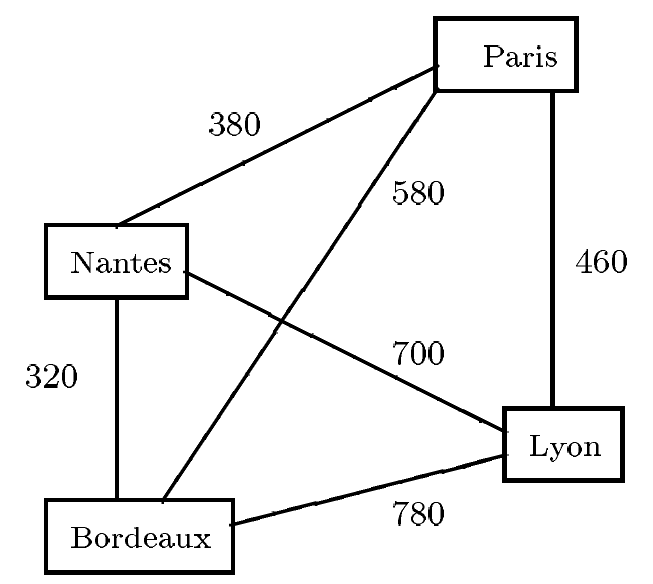
</div>

In [12]:
villes = ["Bordeaux","Lyon","Nantes","Paris"]
df1 = dataF.loc[villes,villes]
del villes

Le chemin le plus court (en commencant depuis Bordeaux par exemple) est
**Bordeaux Nantes Paris Lyon Bordeaux**
avec une distance de **1940** km.

En utilisant l'algorithme de *Little* :

In [13]:
l = Little(df1)
out = l.solve()
del l
print("cycle : ", out[0])
print("distance : ", out[1], "km")

cycle :  ['Bordeaux', 'Nantes', 'Paris', 'Lyon', 'Bordeaux']
distance :  1940.0 km


Ou en utilisant la programmation linéaire :

In [14]:
p = PL_voyage(df1)
out = p.solve()
del p, df1
print("cycle : ", out[0])
print("distance : ", out[1], "km")

cycle :  ['Bordeaux', 'Lyon', 'Paris', 'Nantes', 'Bordeaux']
distance :  1940.0 km


### Voyage dans 6 villes

Cet exemple est l'exemple précédent mais avec deux villes supplémentaires (Montpellier et Dijon).

Le chemin le plus court (en commencant depuis Paris) est **Paris Dijon Lyon Montpellier Bordeaux Nantes Paris** avec une distance de **1990** km.

On peut remarquer que malgré le nombre de villes visitées plus grand la distance ne change pas beaucoup de celle de l'exemple précédent.

En utilisant l'algorithme de *Little* :

In [15]:
l = Little(dataF)
out = l.solve("Paris")
del l
print("cycle : ", out[0])
print("distance : ", out[1], "km")

cycle :  ['Paris', 'Dijon', 'Lyon', 'Montpellier', 'Bordeaux', 'Nantes', 'Paris']
distance :  1990.0 km


Ou en utilisant la programmation linéaire :

(*Si cette opération ne fonctionne pas chez vous, retirez la variable 'solveur' ci-dessous*)

In [16]:
p = PL_voyage(dataF)
out = p.solve("Paris",solv=gurobiSolv)
del p, dataF
print("cycle : ", out[0])
print("distance : ", out[1], "km")

cycle :  ['Paris', 'Nantes', 'Bordeaux', 'Montpellier', 'Lyon', 'Dijon', 'Paris']
distance :  1990.0 km


## Le globe trotter

Cet exemple a été imaginé par moi-même afin de prendre en compte un graphe orienté. Le modèle proposé est plus que discutable et sert uniquement à titre d'exemple / cas d'école.

Un globe-trotter français souhaite visiter 4 capitales différentes en partant de Paris :
- Reykjavik (Islande)
- Kuala Lumpur (Malaisie)
- Sri Jayawardenapura Kotte (Sri Lanka)
- Islamabad (Pakistan)

Il a tout le temps qu'il souhaite pour faire son voyage. Cependant il souhaite **minimiser** l'argent qu'il mettra dans le transport. On suppose que le prix d'un billet de transport pour aller d'une capitale à une autre dépend :
- de la distance entre les deux capitales
- du PIB / habitant du pays **de départ** (d'où l'aspect orienté)

Le prix (en €) d'un billet est donc modélisé par cette relation :

$$prix = C * d * \frac{P_{départ}}{P_{min}}$$
Avec :
- **C** le facteur de réduction ;
- **d** la distance entre les deux capitales ;
- $P_{départ}$ le PIB / habitant du pays de départ ;
- $P_{min}$ le plus petit PIB / habitant dans le monde.

L'ensemble des données utilisées pour cet exemple ainsi que les sources se trouvent dans le fichier "globe trotter.xlsx".
La matrice d'adjacence de ce problème est la suivante (les prix étant en €) :

In [17]:
dataF = fileToDf("data/globe_trotter.txt", False)
dataF

,France,Islande,Malaisie,Sri Lanka,Pakistan
France,NaN,414.0,2007.0,1635.0,1135.0
Islande,495.0,NaN,1045.0,2225.0,1539.0
Malaisie,1331.0,579.0,NaN,313.0,579.0
Sri Lanka,488.0,554.0,141.0,NaN,175.0
Pakistan,139.0,158.0,107.0,72.0,NaN


In [18]:
l = Little(dataF)
out = l.solve("France")
print("Meilleur cycle : ",out[0])
print("Le globe trotteur paiera pour le transport {} €".format(out[1]))

Meilleur cycle :  ['France', 'Islande', 'Malaisie', 'Sri Lanka', 'Pakistan', 'France']
Le globe trotteur paiera pour le transport 2086.0 €


In [19]:
p = PL_voyage(dataF)
out = p.solve("Paris",solv=gurobiSolv)
print("Meilleur cycle : ",out[0])
print("Le globe trotteur paiera pour le transport {} €".format(out[1]))

Meilleur cycle :  ['France', 'Islande', 'Malaisie', 'Sri Lanka', 'Pakistan', 'France']
Le globe trotteur paiera pour le transport 2086.0 €


# Tests d'efficacité

Indique où se situe le répertoire de test. mettre "" si les fichiers sont à la racine.

In [20]:
repTest = "tests/"

Certains tests d'efficacité ont également été rédigés dans des fichiers .py . En effet j'ai pu remarquer que Jupyter ralentissait souvent les calculs et j'ai choisi de faire les "gros calculs" avec Anaconda Prompt / IPython.

## Comparaison Little - Programmation linéaire

Dans cette première partie nous allons pouvoir observer l'évolution du temps d'évaluation des deux méthodes proposées (Little & Programmation Linéaire) et les comparer.

Pour ce test d'efficacité, on va utiliser un graphe recensant 16 villes bretonnes ou proche de la Bretagne via la fonction *filteToDf*. La pondération des arrêtes représente la distance à parcourir à pied pour aller d'un sommet à l'autre. Ces données ont été obtenues sur *Google Maps*. Le graphe est supposé non-orienté.

La quantité de noeuds est ici petite car a priori l'algorithme de Little risque de ne pas pouvoir prendre en compte énormément de noeuds.

Les résultats sont disponibles ci-dessous sous forme de graphiques. Les conclusions seront discutées **lors de l'oral**.

In [21]:
dataF = fileToDf("data/Villes_Bretagne.txt",False)
dataF.iloc[:7,:7]

,Loudéac,Carhaix,Fougères,Vannes,Rennes,Nantes,Angers
Loudéac,NaN,67.0,128.0,64.0,87.0,153.0,201.0
Carhaix,67.0,NaN,193.0,104.0,154.0,212.0,263.0
Fougères,128.0,193.0,NaN,151.0,47.0,142.0,120.0
Vannes,64.0,104.0,151.0,NaN,104.0,111.0,180.0
Rennes,87.0,154.0,47.0,104.0,NaN,111.0,121.0
Nantes,153.0,212.0,142.0,111.0,111.0,NaN,88.0
Angers,201.0,263.0,120.0,180.0,121.0,88.0,NaN


**Cette cellule, obligatoire pour la suite (comparaisons) peut prendre un peu de temps à être exécutée.**

In [22]:
nLit = np.arange(4,len(dataF)+1) #Sert plus tard
little = []
t2 = []
for i in nLit:
    d = dataF.iloc[:i,:i]
    l = Little(d)
    p = PL_voyage(d)
    s = time()
    out = l.solve()
    if out[0] == None:
        print("Erreur sur Little")
    little += [time() - s]
    s = time()
    p.solve(solv=gurobiSolv)
    t2 += [time() - s]
    
little = np.array(little) # Sert plus tard

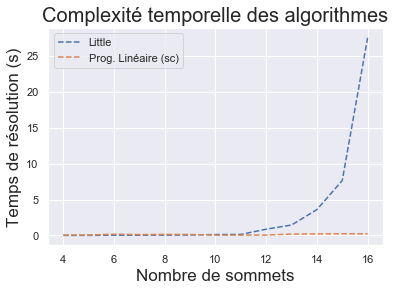

In [23]:
fig = plt.figure()
ax = plt.axes()
plt.title("Complexité temporelle des algorithmes", fontSize=20)
plt.plot(nLit,little,linestyle="dashed", label="Little")
plt.plot(nLit,t2,linestyle="dashed", label="Prog. Linéaire (sc)")
plt.legend()
plt.xlabel("Nombre de sommets", fontSize=17)
ax = plt.ylabel("Temps de résolution (s)", fontsize=17)

Ce que l'on peut remarquer :

L'algorithme de Little nécessite bien plus rapidement du temps pour résoudre le problème du voyageur. On peut considérer qu'à partir de **15-16 noeuds**, ce dernier prendra trop de temps pour être utilisé. De plus, la programmation linéaire (PL) est à tout moment au moins égale si ce n'est **meilleure** en durée de résolution. La PL sera donc privilégiée par la suite, notamment pour faire des tests sur des graphes comportant plus de noeuds.
L'algorithme de Little n'est cependant évidemment pas à jeter. Jusqu'à 10 noeuds environ les temps de résolution sont relativement équivalents (à échelle humaine). De plus le pseudo-code lié à cet algorithme est entièrement transparent (on peut savoir à chaque instant les calculs qui sont réalisés, et pourquoi ils le sont).

## Etude et comparaison des protocoles "PL"

Ici nous allons observer et comparer l'efficacité des deux protocoles de Programmation Linéaire implémentés. Ces protocoles seront testés **sous CBC** puis **sous Gurobi**.

D'après le test précédent, la programmation linéaire peut résister à un nombre bien plus élevé de noeuds que l'algorithme de Little. 

Afin de pouvoir avoir une vision correcte du fonctionnement des protocoles, nous allons réitérer plusieurs fois les différentes opérations en réalisant à chaque étape un graphe aléatoire.

Les calculs prenant beaucoup de temps, l'idée a été d'enregistrer les données dans un fichier txt. Chaque fois que de nouveaux calculs sont fait ils sont rajoutés au fichier txt afin d'affiner les résultats (sauf exception).

*Attention cela peut prendre du temps, certainement plusieurs minutes.* Pour cette raison, il est indiqué par défaut que le programme ne doit pas faire aucune itération (nbBoucles = 0) et donc simplement charger le fichier, s'il existe bien entendu. Mais vous pouvez très bien tester ces calculs en indiquant un nombre entier d'itérations à réaliser, et même changer les noeuds à étudier.

### Constance des résultats

Afin de pouvoir utiliser plusieurs itérations nous voulons voir si la durée de résolution d'un problème fixé reste stable. Sinon l'intérêt de faire de nombreuses itérations avec des problèmes différents a peu d'intérêt. Pour ce faire nous allons faire de nombreuses itérations sur **un même problème** avec **un nombre de noeuds fixés**. Le test a été réalisé **200 fois** sur un graphe généré aléatoirement comportant **60 noeuds**.
Pour réaliser de nouveau le test il suffit de mettre start. Il est à noter cependant qu'en cas de nouveau calcul les données précédentes seront effacées car ce graphe n'a d'intérêt qu'à problème fixé.

,sc,MTZ
moyenne (s),2.778120,24.214215
écart-type (s),0.268347,0.584327


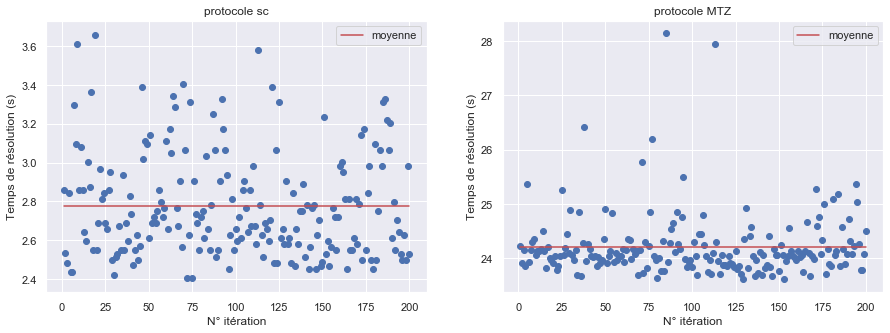

In [24]:
start = False

nomF = repTest + "test_constance_gurobi.txt"

if start:
    n = [60]*200
    if os.path.isfile(nomF):
        os.remove(nomF)
    open(nomF,"w").close()
    nomF = test_temporel_PL(nomF,n,1,None, ["sc","MTZ"],affichage="ratio")


data = lecture_fichier_PL(nomF,retourMoyenne=False)
gurobi = data[2]
fig = plt.figure(figsize=(15,5))

fig.add_subplot(1,2,1)
x = np.arange(1,len(gurobi['sc'])+1)
mSC = np.mean(gurobi['sc'])
sdSC = np.std(gurobi['sc'])
plt.title("protocole sc")
plt.xlabel("N° itération")
plt.ylabel("Temps de résolution (s)")
plt.scatter(x,gurobi['sc'])
plt.plot([1,len(gurobi['sc'])],[mSC,mSC], label="moyenne",color='r')
plot = plt.legend()


fig.add_subplot(1,2,2)
x = np.arange(1,len(gurobi['MTZ'])+1)
mMTZ = np.mean(gurobi['MTZ'])
sdMTZ = np.std(gurobi['MTZ'])
plt.title("protocole MTZ")
plt.xlabel("N° itération")
plt.ylabel("Temps de résolution (s)")
plt.scatter(x,gurobi['MTZ'])
plot = plt.plot([1,len(gurobi['MTZ'])],[mMTZ,mMTZ], label="moyenne",color='r')
plot = plt.legend()

pd.DataFrame(np.array([[mSC,mMTZ],[sdSC,sdMTZ]]),
             index=["moyenne (s)","écart-type (s)"], columns=["sc", "MTZ"])

A problème fixé le temps de résolution reste globalement autour de la moyenne (petit écart-type) ; pour les deux protocoles.

### Observation sur les solveurs et comparaison

Pour commencer nous utiliserons des graphiques composés de **40 nœuds**, valeur plus élevée que celle réalisable via Little mais qui paraît appropriée pour une première évaluation.

*Initialisation des variables*

In [25]:
nbNoeuds = 40
nbBoucles = 0

n = list(range(3,int(nbNoeuds / 2),3))
while n[-1] + 5 < nbNoeuds:
    n.append(n[-1] + 5)
if nbNoeuds not in n:
    n.append(nbNoeuds)
    
n = np.array(n)
nomF = repTest + "test_protocole_pl_" + str(nbNoeuds) + ".txt"

*Calcul de la ou des itérations*

*Enregistrement dans un fichier .txt*

In [26]:
nomF = test_temporel_PL(nomF,n,nbBoucles)
del nbNoeuds, nbBoucles

Données enregistrées dans le fichier : tests/test_protocole_pl_40.txt

Terminé


*Récupération de l'ensemble des données (temps moyen)*

In [27]:
# Calcul du temps moyen
data = lecture_fichier_PL(nomF)
n = data[0]
cbc = data[1]
gurobi = data[2]

*Affichage sous forme de nuage de points*

le nombre d'itérations pour chaque méthode est indiqué dans la légende.



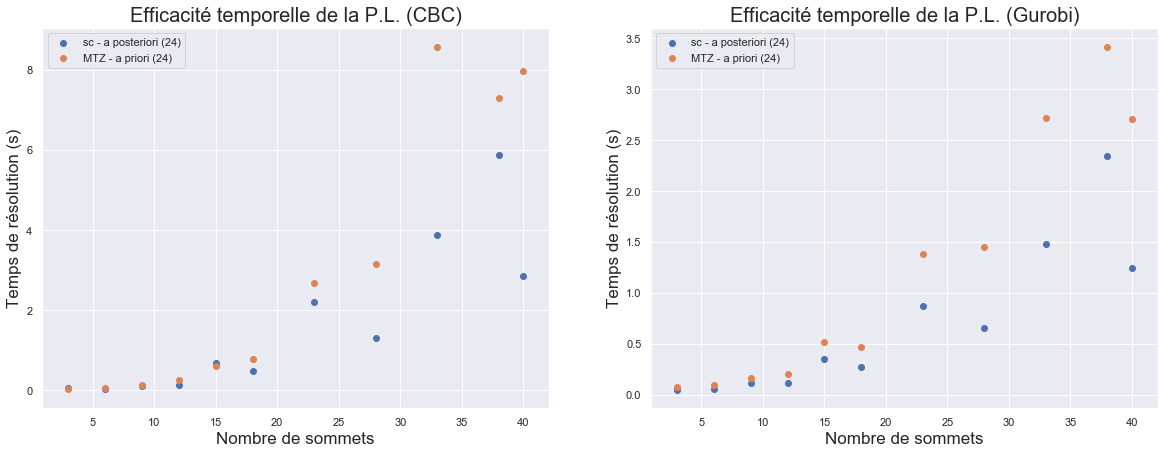

In [28]:
fig_PL(n,cbc,gurobi)

In [29]:
moyennes = pd.DataFrame(np.zeros((2,2)),index=["sc","MTZ"],columns=["CBC","GUROBI"])
moyennes.loc["sc","CBC"] = np.mean(cbc['sc']/n)
moyennes.loc["MTZ","CBC"] = np.mean(cbc['MTZ']/n)
moyennes.loc["sc","GUROBI"] = np.mean(gurobi['sc']/n)
moyennes.loc["MTZ","GUROBI"] = np.mean(gurobi['MTZ']/n)
print("Temps moyen par nombre de noeuds (s)")
moyennes

Temps moyen par nombre de noeuds (s)


,CBC,GUROBI
sc,0.055493,0.025913
MTZ,0.092791,0.044720


On peut déjà remarquer que le solveur CBC est beaucoup plus lent que GUROBI en moyenne. Afin de faire des tests avec plus de noeuds nous allons donc nous restreindre exclusivement à l'utilisation de **GUROBI**.

Il faut cependant faire attention aux conclusions du type "le protocole MTZ est moins-bon que le protocole sc". Même si c'est visiblement le cas ici, le nombre de sommets est assez petit. Etant donnés la nature des protocoles il sera plus judicieux de conclure ce genre de choses avec une plus grande quantité de noeuds.

*Initialisation des variables*

In [30]:
nbNoeuds = 150
nbBoucles = 0

n = np.arange(10,nbNoeuds+1,10)
nomF = repTest + "test_gurobi_" + str(nbNoeuds) + ".txt"

*Calcul de la ou des itérations*

*Enregistrement dans un fichier .txt*

In [31]:
test_temporel_PL(nomF,n,nbBoucles,None, ['sc','MTZ'])
del nbNoeuds, nbBoucles

Données enregistrées dans le fichier : tests/test_gurobi_150.txt

Terminé


*Récupération de l'ensemble des données (temps moyen)*

In [32]:
# Calcul du temps moyen
data = lecture_fichier_PL(nomF)
n = data[0]
gurobi = data[2]

*Affichage sous forme de nuage de points*

le nombre d'itérations pour chaque méthode est indiqué dans la légende.



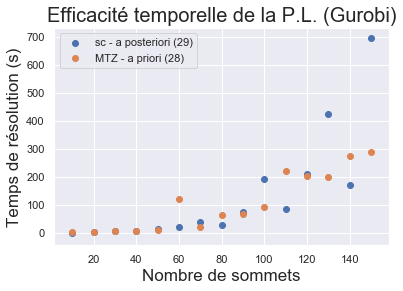

In [33]:
fig_PL(n,None,gurobi)

Ici la tendance change légèrement : en moyenne le protocole **MTZ** est plus rapide que le protocole **sc**. Ce qui semble assez raisonnable étant donné que plus il y a de noeuds, plus il y a de sous-cycle à supprimer (en *moyenne*).

Il est à noter cependant qu'avec les données utilisées **peu de sous-cycles optimaux sont réalisables**, la génération aléatoire ne prenant pas vraiment compte de la logique des distances.

# Analyse et Hypothèses sur la complexité temporelle

Maintenant que nous avons vu qualitativement comment se comportent les algorithmes sur une portion relativement importante (16 pour Little, 150 pour la PL) de noeuds, nous pouvons tenter quelques conjectures rapport à leur complexité temporelle.

Voyons ce qu'il se passe si l'on observe le log du temps de résolution :

In [34]:
xLabl = "Nombre de noeuds"
yLabl = "ln(t)"
titre = "Evolution logarithmique du temps de résolution"

### Little

Il est très important de noter ici que Little est un cas particulier. En effet on ne se base que sur une itération. Cependant l'algorithme de Little peut s'emballer rapidement (voir contre-exemple plus loin). Nous allons donc nous contenter de cette seule itération, en notant bien les conséquences que cela a sur les résultats.

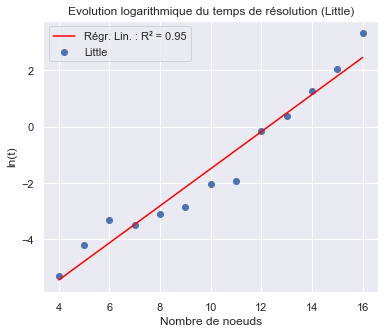

In [35]:
little = np.array(little)
fig = plt.figure(figsize=(6,5))
plt.title(titre + " (Little)")
plt.xlabel(xLabl)
plt.ylabel(yLabl)
plt.scatter(nLit,np.log(little), label="Little")

regLit = LinearRegression()
regLit.fit(nLit.reshape(-1,1), np.log(little))
RsqLit = regLit.score(nLit.reshape(-1,1),np.log(little))
coeffLit = regLit.coef_[0]
plt.plot([4,16],regLit.intercept_ + np.array([4,16])*coeffLit,
        label="Régr. Lin. : R² = " + str(round(RsqLit,2)), color="red")
plot = plt.legend()

### PL - SC

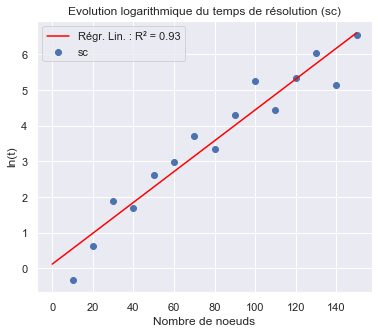

In [36]:
fig = plt.figure(figsize=(6,5))
plt.title(titre + " (sc)")
plt.xlabel(xLabl)
plt.ylabel(yLabl)
plt.scatter(n,np.log(gurobi['sc']),label="sc")

regSC = LinearRegression()
regSC.fit(n.reshape(-1,1),np.log(gurobi['sc']))
RsqSC = regSC.score(n.reshape(-1,1),np.log(gurobi['sc']))
coeffSC = regSC.coef_[0]
plt.plot([0,max(n)],[regSC.intercept_,regSC.intercept_ + max(n)*coeffSC],
        label="Régr. Lin. : R² = " + str(round(RsqSC,2)), color="red")
plot = plt.legend()

### PL - MTZ

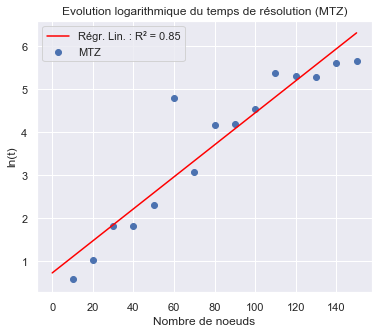

In [37]:
fig = plt.figure(figsize=(6,5))
plt.title(titre + " (MTZ)")
plt.xlabel(xLabl)
plt.ylabel(yLabl)
plt.scatter(n,np.log(gurobi['MTZ']),label="MTZ")

regMTZ = LinearRegression()
regMTZ.fit(n.reshape(-1,1),np.log(gurobi['MTZ']))
RsqMTZ = regSC.score(n.reshape(-1,1),np.log(gurobi['MTZ']))
coeffMTZ = regMTZ.coef_[0]
plt.plot([0,max(n)],[regMTZ.intercept_,regMTZ.intercept_ + max(n)*coeffMTZ],
        label="Régr. Lin. : R² = " + str(round(RsqMTZ,2)), color="red")
plot = plt.legend()

## Comparaison & Spéculations

Les coefficients de Pearson sont suffisamment élevés dans chaque cas pour supposer que nous avons à faire à des **complexités temporelles exponentielles**.

On a pu l'observer sur les graphiques, certaines méthodes sont meilleures que d'autres. Via l'analyse précédente l'hypothèse d'une complexité exponentielle *maximale* de la forme $C.e^{k_i * n}$ semble viable ; avec $C > 0$ et $k_i$ dépendant de la méthode utilisée. Ces $k_i$ correspondant d'ailleurs dans notre modèle au coefficient directeur de la droite de régression linéaire. Ainsi :

*Normalement le coefficient C dépend de chaque algorithme mais pour simplifier on pose $C = \max{C_i}$*

In [38]:
mat = np.array([coeffLit,coeffSC,coeffMTZ])
df = pd.DataFrame(np.empty((1,3)),index=["coefficient k"],columns=["Little","SC","MTZ"])
df.iloc[0,:] = mat
df

,Little,SC,MTZ
coefficient k,0.657931,0.043257,0.037229


En prenant pour l'exemple C = 1, comparons les durées hypothétiques de résolution entre 3 et 200 noeuds :

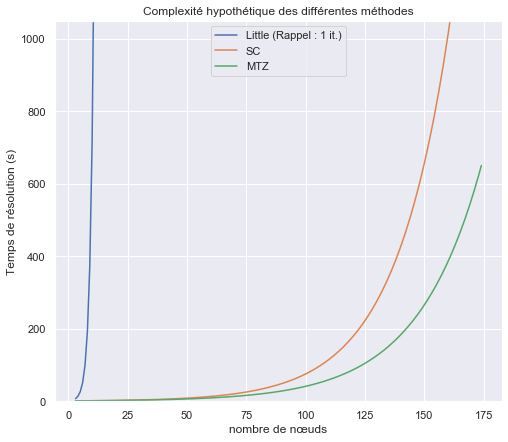

In [39]:
C = 1
fig = plt.figure(figsize=(8,7))
noeuds = np.arange(3,175)
hypLit = C*np.exp(coeffLit*noeuds)
hypSC = C*np.exp(coeffSC*noeuds)
hypMTZ = C*np.exp(coeffMTZ*noeuds)
plt.plot(noeuds,hypLit,label="Little (Rappel : 1 it.)")
plt.plot(noeuds,hypSC,label="SC")
plt.plot(noeuds,hypMTZ,label="MTZ")
plt.ylim((0,1050))
plot = plt.legend()
plt.title("Complexité hypothétique des différentes méthodes")
plt.xlabel("nombre de nœuds")
plot = plt.ylabel("Temps de résolution (s)")

## Contre-exemple et mise en garde

A partir du résultat précédent on pourrait hâtivement conclure que :
- L'algorithme de Little est valable jusque 15-16 noeuds
- La PLNE est bien meilleure que l'algorithme de Little
- Le protocole MTZ est meilleur que le protocole SC, surtout à partir de 75 noeuds.

Même si la vérité s'approche de cela, il faut bien se rappeler que nous avons utilisé peu d'itérations (une seule à vrai dire) pour l'algorithme de Little, ce dernier étant très coûteux en temps et explosant rapidement (impossible de déterminer le temps pour 50 noeuds par exemple). Il est aussi important de noter que dans les graphes générés aléatoirement pour tester la P.L., il est peu probable que des sous-cycles soient générés alors que dans la réalité il y en a souvent bien plus. 

Ces différentes mises en gardes s'expriment plutôt bien dans un exemple intitulé **br17** (17 noeuds) et modélisé par la matrice d'adjacence suivante :

In [40]:
m = np.matrix([[np.nan,3,5,48,48,8,8,5,5,3,3,0,3,5,8,8,5],
                [3,np.nan,3,48,48,8,8,5,5,0,0,3,0,3,8,8,5],
                [5,3,np.nan,72,72,48,48,24,24,3,3,5,3,0,48,48,24],
                [48,48,74,np.nan,0,6,6,12,12,48,48,48,48,74,6,6,12],
                [48,48,74,0,np.nan,6,6,12,12,48,48,48,48,74,6,6,12],
                [8,8,50,6,6,np.nan,0,8,8,8,8,8,8,50,0,0,8],
                [8,8,50,6,6,0,np.nan,8,8,8,8,8,8,50,0,0,8],
                [5,5,26,12,12,8,8,np.nan,0,5,5,5,5,26,8,8,0],
                [5,5,26,12,12,8,8,0,np.nan,5,5,5,5,26,8,8,0],
                [3,0,3,48,48,8,8,5,5,np.nan,0,3,0,3,8,8,5],
                [3,0,3,48,48,8,8,5,5,0,np.nan,3,0,3,8,8,5],
                [0,3,5,48,48,8,8,5,5,3,3,np.nan,3,5,8,8,5],
                [3,0,3,48,48,8,8,5,5,0,0,3,np.nan,3,8,8,5],
                [5,3,0,72,72,48,48,24,24,3,3,5,3,np.nan,48,48,24],
                [8,8,50,6,6,0,0,8,8,8,8,8,8,50,np.nan,0,8],
                [8,8,50,6,6,0,0,8,8,8,8,8,8,50,0,np.nan,8],
                [5,5,26,12,12,8,8,0,0,5,5,5,5,26,8,8,np.nan]])

dataF = pd.DataFrame(m)
dataF

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,NaN,3.0,5.0,48.0,48.0,8.0,8.0,5.0,5.0,3.0,3.0,0.0,3.0,5.0,8.0,8.0,5.0
1,3.0,NaN,3.0,48.0,48.0,8.0,8.0,5.0,5.0,0.0,0.0,3.0,0.0,3.0,8.0,8.0,5.0
2,5.0,3.0,NaN,72.0,72.0,48.0,48.0,24.0,24.0,3.0,3.0,5.0,3.0,0.0,48.0,48.0,24.0
3,48.0,48.0,74.0,NaN,0.0,6.0,6.0,12.0,12.0,48.0,48.0,48.0,48.0,74.0,6.0,6.0,12.0
4,48.0,48.0,74.0,0.0,NaN,6.0,6.0,12.0,12.0,48.0,48.0,48.0,48.0,74.0,6.0,6.0,12.0
5,8.0,8.0,50.0,6.0,6.0,NaN,0.0,8.0,8.0,8.0,8.0,8.0,8.0,50.0,0.0,0.0,8.0
6,8.0,8.0,50.0,6.0,6.0,0.0,NaN,8.0,8.0,8.0,8.0,8.0,8.0,50.0,0.0,0.0,8.0
7,5.0,5.0,26.0,12.0,12.0,8.0,8.0,NaN,0.0,5.0,5.0,5.0,5.0,26.0,8.0,8.0,0.0
8,5.0,5.0,26.0,12.0,12.0,8.0,8.0,0.0,NaN,5.0,5.0,5.0,5.0,26.0,8.0,8.0,0.0
9,3.0,0.0,3.0,48.0,48.0,8.0,8.0,5.0,5.0,NaN,0.0,3.0,0.0,3.0,8.0,8.0,5.0


Cet exemple est assez particulier et permet de bien mettre en évidence les avantages et inconvénients des méthodes proposées. En effet, si nous tentons de résoudre le problème avec Little, il faudra attendre plus que très longtemps (pour 12 noeuds nous sommes par exemple à 1 minute). De même si l'on utilise la P.L. avec le protocole SC la durée sera très grande également. Cependant, avec le protocole MTZ, le résultat est obtenu en quelques secondes avec Gurobi (39 km).

Ce graphe a de particulier que tous les chemins se valent (tous les cycles hamiltoniens sont de même longueur, ou presque) ; et de nombreux sous-cycles existent.
Pour Little, tous les chemins seront donc testés [(n-1)! chemins]
Avec le protocole "SC", il faudra redémarrer de nombreuses fois le solveur car il existe énormément de sous-cycles.
Le protocole "MTZ" sera dont très intéressant ici car il éliminera tous les sous-cycles dès le départ. Donnant ainsi le résultat attendu très rapidement.

**Attention : CBC n'a pas l'air d'apprécier grandement ce problème, pour une raison inconnue. Gurobi réagit beaucoup mieux.**

In [41]:
if True:
    p = PL_voyage(dataF)
    s = time()
    out,dist = p.solve(protocole="MTZ",solv=gurobiSolv)
    print("Distance {} km, résolu en {} s".format(dist,round(time() - s,3)))

Distance 39.0 km, résolu en 0.799 s


# Bibliographie

- *Algorithmes sur les Graphes*, Département Informatique, ISEN Lille
- *Modélisation du problème du voyageur de commerce*, Alain FAYE, ENSIIE
- *TSPLib*, ATSP br17 problem